This tutorial demonstrates how to use int8 operations with OpenCLIP.

Usually matrix multiplies are conducted in float16 or bfloat16, but int8 operations are faster.

For more information please see https://github.com/mlfoundations/open_clip#int8-support

We ran this on an A100 GPU

Note that this tutorial requires two additional pip installs on top of those required for standard OpenCLIP.

In [1]:
# necessary installs for int8
!pip install triton==2.0.0.post1
!pip install bitsandbytes
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


Let's start with using a standard OpenCLIP model

In [2]:
# import packages
import numpy as np
import torch
import open_clip
from open_clip import tokenizer

In [3]:
# load the model
model, _, preprocess = open_clip.create_model_and_transforms('ViT-H-14', pretrained='laion2b_s32b_b79k')
model.eval()
model = model.cuda()

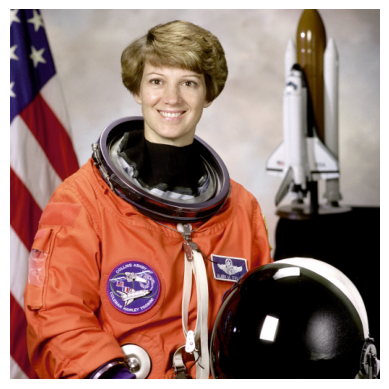

In [4]:
# lets check out the example image we will be using for classification
import matplotlib.pyplot as plt
from skimage import data, data_dir
import os
from PIL import Image
%matplotlib inline

img = data.astronaut()

plt.imshow(img)
plt.axis('off')
plt.show()

In [5]:

# preprocess image and text
img = Image.open(os.path.join(data_dir, 'astronaut.png')).convert("RGB")
img_preprocessed = preprocess(img).cuda().unsqueeze(0)

descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}
texts = descriptions.values()

text_processed = tokenizer.tokenize(texts).cuda()

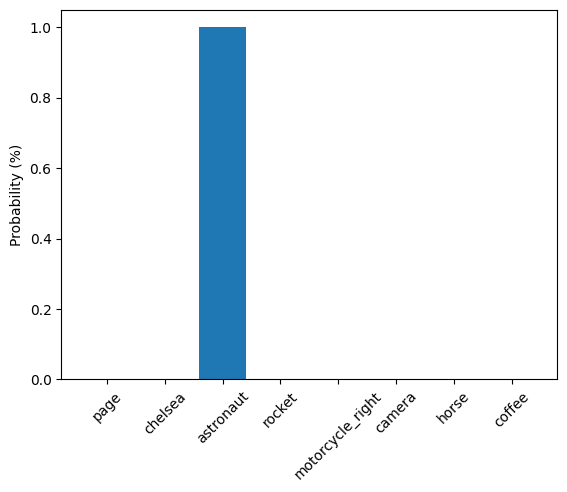

In [6]:
# get predictions from the model
with torch.cuda.amp.autocast():
    img_embedding, text_embedding, _ = model(img_preprocessed, text_processed)
probs = (100 * img_embedding @ text_embedding.T).softmax(dim=-1)
plt.bar(descriptions.keys(), probs.squeeze().detach().cpu().numpy())
plt.xticks(rotation=45)
plt.ylabel('Probability (%)')
plt.show()

Before we move on to int8, lets get a feel for how fast things are in general, for a batch of size 128.

In [7]:
import time
def get_time(k, fn, repeat=32):

    for _ in range(repeat // 2):
       fn()

    torch.cuda.synchronize()
    start = time.time()
    for _ in range(repeat):
       fn()

    torch.cuda.synchronize()
    end = time.time()
    ms = (end - start) / repeat * 1000
    print(f"time {k}: {ms:.3f} ms")
    return ms

In [8]:
fake_img_batch = torch.randn(128, 3, 224, 224).cuda()
fake_txt_batch = torch.randint(0, 100, (128, 77)).cuda()
model.set_grad_checkpointing()
model.eval()
def fake_forward(model, fake_img_batch, fake_txt_batch):
    with torch.cuda.amp.autocast():
        model(fake_img_batch, fake_txt_batch)
time_standard = get_time("standard", lambda: fake_forward(model, fake_img_batch, fake_txt_batch))


time standard: 442.668 ms


Let's repeat the previous steps but change the linear layer operations to quantized in8.

In [9]:
# This replaces linear layers with int8_linear_layer
import bitsandbytes as bnb
model = model.cpu()
int8_linear_layer = bnb.nn.triton_based_modules.SwitchBackLinear
# replace linear layers, for now just replace FFN - more coming in later PR
int8_model = open_clip.utils.replace_linear(model, int8_linear_layer, include_modules=['c_fc', 'c_proj']).cuda()



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /admin/home-mitchellw/git/bitsandbytes/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /fsx/home-mitchellw/miniconda3/envs/py2/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /admin/home-mitchellw/git/bitsandbytes/bitsandbytes/libbitsandbytes_cuda118.so...


In [10]:
# repeat the speed test. may take a sec to run this because it has to compile the kernels.
int8_model.set_grad_checkpointing()
int8_model.eval()
time_int8_v1 = get_time("int8-v1", lambda: fake_forward(int8_model, fake_img_batch, fake_txt_batch))


time int8-v1: 391.433 ms


If you just care about inference you can make things go faster by precomputing the int8 quantized weights and deleting the original weights. This is what you should do if you're not training as it's also much less memory. We'll explain later in more detail.


In [11]:
# prepare for eval by deleting the original weights and storing the quantized version of the weights
from open_clip.utils import convert_int8_model_to_inference_mode
convert_int8_model_to_inference_mode(int8_model)


=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparing for eval.
=> preparin

In [12]:
# Repeat speed test but with pre-quantized weights
time_int8_v2 = get_time("int8-v2", lambda: fake_forward(int8_model, fake_img_batch, fake_txt_batch))

time int8-v2: 382.608 ms


Let's make sure the model still works

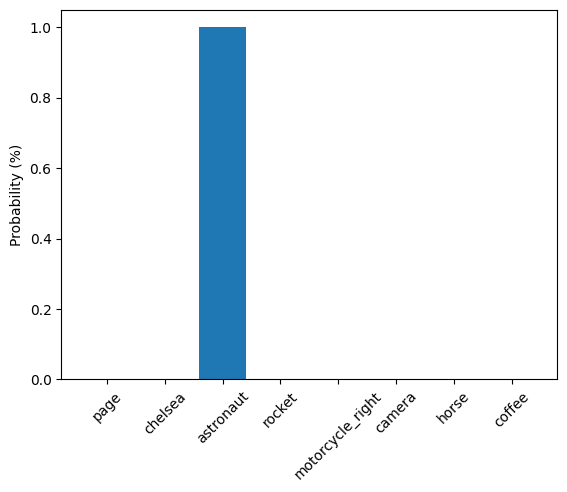

In [13]:
# lets make sure it still works
with torch.cuda.amp.autocast():
    img_embedding, text_embedding, _ = int8_model(img_preprocessed, text_processed)
probs = (100 * img_embedding @ text_embedding.T).softmax(dim=-1)
plt.bar(descriptions.keys(), probs.squeeze().detach().cpu().numpy())
plt.xticks(rotation=45)
plt.ylabel('Probability (%)')
plt.show()


Nice! However, our int8 linear layer actually uses the PyTorch autograd python module, whereas the default PyTorch linear layer contains C++ optimizations...

So to understand the true speed-ups lets look at how fast the fair baseline is, which is a standard linear layer implemented with autograd.

In [14]:
del model, int8_model
model, _, preprocess = open_clip.create_model_and_transforms('ViT-H-14', pretrained='laion2b_s32b_b79k')
model = open_clip.utils.replace_linear(model, bnb.nn.triton_based_modules.StandardLinear, include_modules=['c_fc', 'c_proj']).cuda()

In [15]:
# how fast is this baseline which uses the autograd linear?
model.set_grad_checkpointing()
model.eval()
time_baseline = get_time("baseline", lambda: fake_forward(model, fake_img_batch, fake_txt_batch))

time baseline: 521.073 ms


Now let's compare end-to-end speed

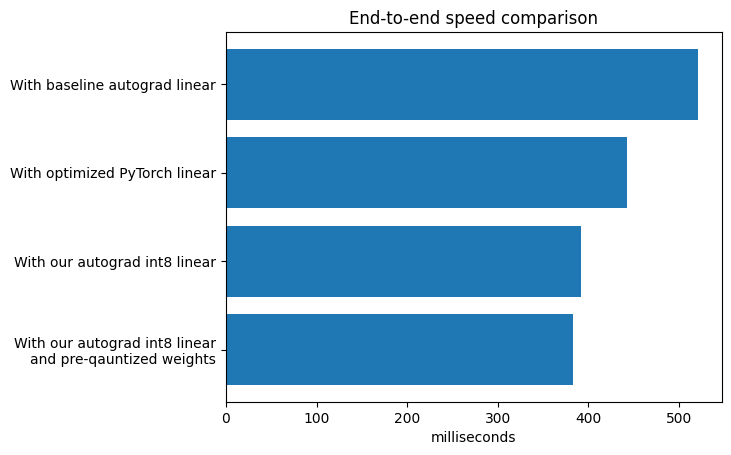

speedup over autograd linear 24.88%
speedup over optimized linear 11.57%


In [16]:
# now lets compare the speed-ups!
labels = ['With baseline autograd linear', 'With optimized PyTorch linear', 'With our autograd int8 linear', 'With our autograd int8 linear\nand pre-qauntized weights']
data = [time_baseline, time_standard, time_int8_v1, time_int8_v2]
labels.reverse()
data.reverse()
plt.barh(labels, data)
plt.title('End-to-end speed comparison')
plt.xlabel('milliseconds')
plt.show()
print('speedup over autograd linear {:.2f}%'.format(100 * (time_baseline - time_int8_v1) / time_baseline))
print('speedup over optimized linear {:.2f}%'.format(100 * (time_standard - time_int8_v1) / time_standard))

How does it work? Let's go through the steps of a normal and quantized forward pass with batch X [b, n] and weights W [m, n]

Starting with a normal forward pass

In [17]:
import numpy as np
X = torch.randn(128, 1024).half().cuda()
W = (1/np.sqrt(1024)) * torch.randn(4096, 1024).half().cuda()

# here is a standard forward pass
standard_out = torch.matmul(X, W.t())

Now let's look at a quantized forward pass, for now lets assume that the quantized weights are not pre-computed

In [18]:
# This operation quantizes and casts X to int8. Each row is quantized independently by dividing by the absolute max value in the row then multiplying by 127 and roundnig.
# state_X stores the absolute max of each row
X_int8, state_X = bnb.nn.triton_based_modules.quantize_rowwise(X)

# For the weights we do tensor-wise quantization, so we quantize using the absolute max of the entire tensor.
# During inference weights can be "pre-quantized" so this step does not happen -- this is what "prepare_for_eval" did above.
W_int8, state_W = bnb.nn.triton_based_modules.quantize_global(W)

# Now we do a fused matmul and dequantize operation
int8_out = bnb.nn.triton_based_modules.int8_matmul_mixed_dequanitze(X_int8, W_int8.t(), state_X, state_W, None)

# comparing the difference
print('Difference due to quantization', (int8_out - standard_out).abs().mean().item())

Difference due to quantization 0.01125335693359375
